In [2]:
#This Notebook takes a eeg data recorded from a Muse Headset using Mind Moniter and utilizes methods described in the paper 
# "Individual alpha frequency proximity associated with repetitive transcranial magnetic stimulation outcome: 
#  An independent replication study from the ICON-DB consortium".

#Import Libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.fft as scipyfft
from scipy.signal import get_window
import scipy.signal

%matplotlib inline

In [10]:
FILE = 'example.csv' #The file with the data
IMAGE_FILE_LABEL = 'example' #What you would like image files to be named when saved
IMAGE_FOLDER = 'Example_Images' #The folder to save images to.

#Load Data into dataframe
data = pd.read_csv(f'./{FILE}')
tp9_raw = data['RAW_TP9'].tolist()
af7_raw = data['RAW_AF7'].tolist()
af8_raw = data['RAW_AF8'].tolist()
tp10_raw = data['RAW_TP10'].tolist()

<ipython-input-10-119f6f75f991>:6: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(f'./{FILE}')


Data Lengths:  23148 23148 23148 23148


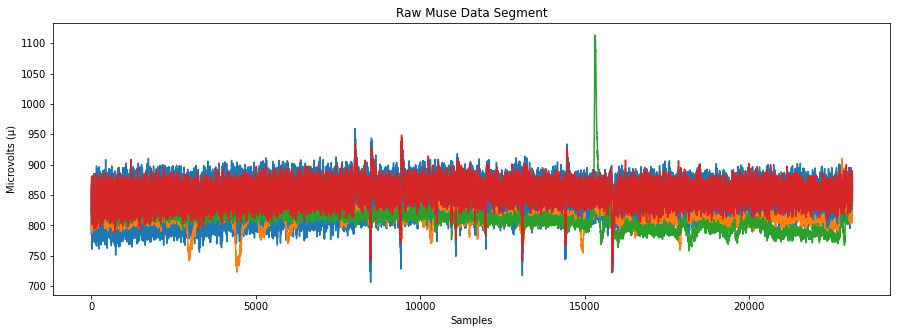

In [11]:
#This is the area where one can manipulate or change signals independently with the most ease prior to the rest of this notebooks methods.

#Function to eliminate Nan/Event Based Data stream disruptions. There is actually a better method for this implimented in some of my later notebooks
# will update soon
def clean_nans(data_list):
    output = []
    for x in data_list:
        if np.isnan(x) == False:
            output.append(x)
    return output

tp9 = clean_nans(tp9_raw)
tp10 = clean_nans(tp10_raw)
af7 = clean_nans(af7_raw)
af8 = clean_nans(af8_raw)

print('Data Lengths: ', len(tp9), len(af7), len(af8), len(tp10))
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title('Raw Muse Data Segment')
ax.set_xlabel('Samples')
ax.set_ylabel('Microvolts (µ)')
ax.plot(tp9)
ax.plot(af7)
ax.plot(af8)
ax.plot(tp10)

DataStart & End:  0 20000


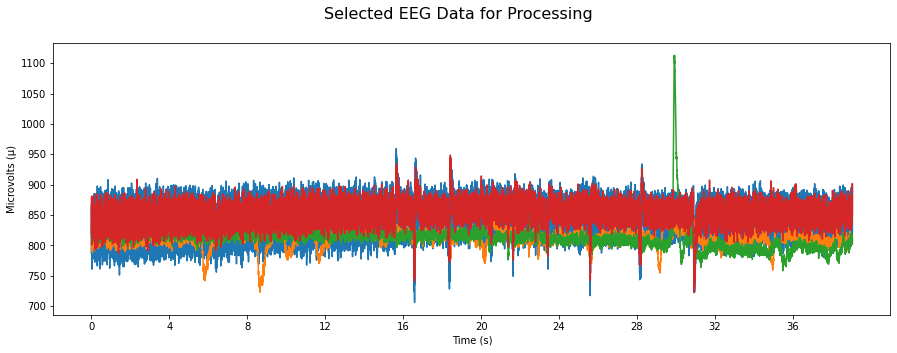

In [12]:
# Create a smaller section to analyze from the complete recording. 
# Data sent to the next code block is then segmented for FFT.
data_start = 0
data_end = 20000

print('DataStart & End: ', data_start, data_end)
raw_data = np.asarray([tp9,af7,af8,tp10]) #Condense for more processing

#Plot the Section
fig, ax = plt.subplots(figsize=(15,5))
fig.suptitle('Selected EEG Data for Processing', fontsize=16)
x = np.arange(0, (data_end-data_start), 2048) #sets axes
xlab = 4 * np.arange(0, len(x), 1)

ax.set_xlabel('Time (s)')
ax.set_xticks(x)
ax.set_xticklabels(xlab)
ax.set_ylabel('Microvolts (µ)')

ax.plot(raw_data[0][data_start:data_end])
ax.plot(raw_data[1][data_start:data_end])
ax.plot(raw_data[2][data_start:data_end])
ax.plot(raw_data[3][data_start:data_end])

plt.savefig(f'./{IMAGE_FOLDER}/{IMAGE_FILE_LABEL}_raweeg_section.png', bbox_inches='tight')

In [13]:
#This code block seperates the data into chunks for FFT processing.

segment_duration = 2 #Length in seconds of sections to FFT
section_overlap = 0.98 #Percentage Overlap of each section, this is converted to a sample overlap number
sr = sample_rate = 256 #The sample rate of the data, 256Hz for the Muse 3

####################################################
chunk_len = segment_duration * sr 
chunk_overlap = int(chunk_len * (1-section_overlap))
fft_len = chunk_len

print('Data Length: ', data_end-data_start)
print('Segement Duration (s): ', segment_duration)
print('Frequency Resolution (hz): ', sr/fft_len)
print('Time Resolution (s): ', fft_len/sr)

def chunk_data(raw_sensor_data, data_start, data_end, sensor_id, chunk_len, chunk_overlap):
    
    print()
    print('OPERATING ON SENSOR {}'.format(sensor_id))
    data_section = [] #Init Empty
    data_section = raw_sensor_data[data_start:data_end]
    print('Sensor {} data len {}'.format(sensor_id, len(data_section)))
    
    data_chunks = [data_section[x:x+chunk_len] for x in range(0, len(data_section), chunk_overlap)]
    print('Chunk Len: ', chunk_len)
    print('Data Chunks Made: ', len(data_chunks))
    print('Sample Overlap: ', chunk_overlap)
    
    mi = 0
    for i in range(len(data_chunks)-1,-1,-1):
        if len(data_chunks[i]) != chunk_len:
            mi = i
    i = mi - len(data_chunks)
    data_chunks = data_chunks[:i]
    print('Num Chunks w/rm: ', len(data_chunks))
    return data_chunks

tp9_data_chunks = chunk_data(raw_data[0], data_start, data_end, 0, chunk_len, chunk_overlap)
tp10_data_chunks = chunk_data(raw_data[3], data_start, data_end, 3, chunk_len, chunk_overlap)
af7_data_chunks = chunk_data(raw_data[1], data_start, data_end, 1, chunk_len, chunk_overlap)
af8_data_chunks = chunk_data(raw_data[2], data_start, data_end, 2, chunk_len, chunk_overlap)

Data Length:  20000
Segement Duration (s):  2
Frequency Resolution (hz):  0.5
Time Resolution (s):  2.0

OPERATING ON SENSOR 0
Sensor 0 data len 20000
Chunk Len:  512
Data Chunks Made:  2000
Sample Overlap:  10
Num Chunks w/rm:  1949

OPERATING ON SENSOR 3
Sensor 3 data len 20000
Chunk Len:  512
Data Chunks Made:  2000
Sample Overlap:  10
Num Chunks w/rm:  1949

OPERATING ON SENSOR 1
Sensor 1 data len 20000
Chunk Len:  512
Data Chunks Made:  2000
Sample Overlap:  10
Num Chunks w/rm:  1949

OPERATING ON SENSOR 2
Sensor 2 data len 20000
Chunk Len:  512
Data Chunks Made:  2000
Sample Overlap:  10
Num Chunks w/rm:  1949


In [14]:
#Purge Chunks with jumps in microvoltage above the Delta Limit.
delta_lim = 150

def microvolt_purge(delta_lim, data):
    
    out_data = []
    chunk_index = 0
    
    for chunk in data:
        testpass = 0
        for i, j in zip(chunk, chunk[1:]): 
            if np.abs(j-i) > delta_lim:
                testpass = 1
                chunk_index+=1

        chunk_index+=1
        if testpass == 0:
            out_data.append(chunk)
            
    print('total chunks: ', len(data))
    print("chunks passed: ", len(out_data))
    print("Percent Used: ", (100* (len(out_data)/len(data))))
            
    return(out_data)

print('Sensor Tp9:')
tp9_data = microvolt_purge(delta_lim, tp9_data_chunks)
print('\nSensor Tp10:')
tp10_data = microvolt_purge(delta_lim, tp10_data_chunks)
print('\nSensor Af7:')
af7_data = microvolt_purge(delta_lim, af7_data_chunks)
print('\nSensor Af8:')
af8_data = microvolt_purge(delta_lim, af8_data_chunks)

Sensor Tp9:
total chunks:  1949
chunks passed:  1949
Percent Used:  100.0

Sensor Tp10:
total chunks:  1949
chunks passed:  1949
Percent Used:  100.0

Sensor Af7:
total chunks:  1949
chunks passed:  1949
Percent Used:  100.0

Sensor Af8:
total chunks:  1949
chunks passed:  1949
Percent Used:  100.0


In [15]:
#A simple function that applies a hamming window to each fft section, returning the real frequencies for use.

def hamm_spectrum(s, sr, hamm=True):
    s  = s - np.mean(s)
    window = scipy.signal.windows.hamming(len(s)) 
    sh = window * s if hamm else s
    
    sf = np.fft.rfft(sh)
    return np.abs(sf)

In [16]:
#This Block creates a series of filters for the data and applies them prior to an FFT

order = 100
lp_cutoff = 100 #hz
hp_cutoff = 1 #hz
notch_cutoff = 60 #hz
quality_factor = 100

#######################################
t = np.arange(0, chunk_len/sr, 1/sr)
dt = t[1] - t[0]
Nyq = 1/dt/2

pad_len = (chunk_len-order)
lp_freq = lp_cutoff / Nyq
hp_freq = hp_cutoff / Nyq
notch_freq = notch_cutoff / Nyq #

filt_lp = scipy.signal.firwin(order, lp_freq)
filt_hp = scipy.signal.firwin(order+1, hp_freq, pass_zero=False)
notch_a, notch_b = scipy.signal.iirnotch(notch_freq, quality_factor)

def series_filter_fft(data, filt_lp, filt_hp, notch_a, notch_b, pad_len):
    
    data_lp = [scipy.signal.filtfilt(filt_lp, 1, s, padlen=pad_len) for s in data]
    data_hp = [scipy.signal.filtfilt(filt_hp, 1, slp, padlen=pad_len) for slp in data_lp]
    data_notch = [scipy.signal.filtfilt(notch_a, notch_b, shp) for shp in data_hp]
    
    data_fft = [hamm_spectrum(sample, sr) for sample in data_notch]
    
    return data_fft

tp9_fft = series_filter_fft(tp9_data, filt_lp, filt_hp, notch_a, notch_b, pad_len)
tp10_fft = series_filter_fft(tp10_data, filt_lp, filt_hp, notch_a, notch_b, pad_len)
af7_fft = series_filter_fft(af7_data, filt_lp, filt_hp, notch_a, notch_b, pad_len)
af8_fft = series_filter_fft(af8_data, filt_lp, filt_hp, notch_a, notch_b, pad_len)
freqs = np.fft.rfftfreq(n=chunk_len, d=dt)

print('FFTs conducted on TP9: ', len(tp9_fft))
print('FFTs conducted on TP10: ', len(tp10_fft))
print('FFTs conducted on AF7: ', len(af7_fft))
print('FFTs conducted on AF8: ', len(af8_fft))

FFTs conducted on TP9:  1949
FFTs conducted on TP10:  1949
FFTs conducted on AF7:  1949
FFTs conducted on AF8:  1949


FileNotFoundError: [Errno 2] No such file or directory: './Images/Example_Images/example_FFTBySensor.png'

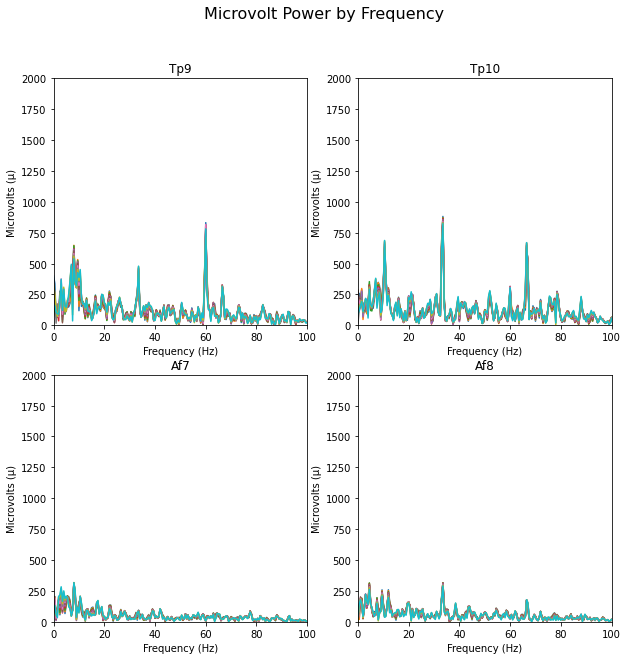

In [17]:
#Plot some of the  FFT's

fig, ax = plt.subplots(2, 2, figsize=(10,10))
fig.suptitle('Microvolt Power by Frequency', fontsize=16)
ylim=2000

ax[0, 0].set_xlim(0,100)
ax[0, 0].set_ylim(0,ylim)
ax[0, 0].set_title('Tp9')
ax[0, 0].set_xlabel('Frequency (Hz)')
ax[0, 0].set_ylabel('Microvolts (µ)')

ax[1, 0].set_xlim(0,100)
ax[1, 0].set_ylim(0,ylim)
ax[1, 0].set_title('Af7')
ax[1, 0].set_xlabel('Frequency (Hz)')
ax[1, 0].set_ylabel('Microvolts (µ)')

ax[0, 1].set_xlim(0,100)
ax[0, 1].set_ylim(0,ylim)
ax[0, 1].set_title('Tp10')
ax[0, 1].set_xlabel('Frequency (Hz)')
ax[0, 1].set_ylabel('Microvolts (µ)')

ax[1, 1].set_xlim(0,100)
ax[1, 1].set_ylim(0,ylim)
ax[1, 1].set_title('Af8')
ax[1, 1].set_xlabel('Frequency (Hz)')
ax[1, 1].set_ylabel('Microvolts (µ)')

for i in range(0,10):
    ax[0, 0].plot(freqs, tp9_fft[i])
    ax[0, 1].plot(freqs, tp10_fft[i])
    ax[1, 0].plot(freqs, af7_fft[i])
    ax[1, 1].plot(freqs, af8_fft[i])
    
plt.savefig(f'./Images/{IMAGE_FOLDER}/{IMAGE_FILE_LABEL}_FFTBySensor.png', bbox_inches='tight')

In [20]:
#Limit the number of FFTs used in Peak finding, if you're into that sorta thing.

start = 0
stop = 1000
def sample_ffts(data, start, stop):  
    data_out = data[start:stop]
    return data_out

tp9_sample = sample_ffts(tp9_fft, start, stop)
tp10_sample = sample_ffts(tp10_fft, start, stop)
af7_sample = sample_ffts(af7_fft, start, stop)
af8_sample = sample_ffts(af8_fft, start, stop)

print('len: ', len(tp9_sample))

len:  1000


In [21]:
#This block locates peaks in a selected range of frequency bands and outputs the largest power peak for the segement.
lowfreq_lim = 7
highfreq_lim = 13

####################################
fr = sr/fft_len #freq resolution
low_index = int(lowfreq_lim/fr)
high_index = int(highfreq_lim/fr)

def alpha_peak_search(data_cutfft, low_index, high_index, fr):
    alpha_bin = []
    alpha_freq = []
    alpha_power = []
    
    for fft in data_cutfft:
        peaks, _  = scipy.signal.find_peaks(fft)
    
        pruned_peaks = []
        for peak in peaks:
            if peak >= low_index and peak <= high_index:
                pruned_peaks.append(peak)
        
        if len(pruned_peaks) == 0:
            pruned_peaks = [0]
        
        alpha_index = [(p, p*fr, fft[p]) for p in pruned_peaks] 
        _, _, i = np.argmax(alpha_index, axis=0)

        alpha_bin.append(alpha_index[i][0])
        alpha_freq.append(alpha_index[i][1])
        alpha_power.append(alpha_index[i][2])
        
    return (alpha_bin, alpha_freq, alpha_power)

tp9_alpha_bin, tp9_alpha_freq, tp9_alpha_power = alpha_peak_search(tp9_sample, low_index, high_index, fr)
tp10_alpha_bin, tp10_alpha_freq, tp10_alpha_power = alpha_peak_search(tp10_sample, low_index, high_index, fr)
af7_alpha_bin, af7_alpha_freq, af7_alpha_power = alpha_peak_search(af7_sample, low_index, high_index, fr)
af8_alpha_bin, af8_alpha_freq, af8_alpha_power = alpha_peak_search(af8_sample, low_index, high_index, fr)

In [22]:
#Eliminate sections whose max peak is not 1.5 zscores above the mean of the section.

def z_score_cut(data_cutfft, alpha_bin, alpha_freq, alpha_power):
    z = []
    IAF = []
    IAF_pow = []
    
    for fft in data_cutfft:
        z.append(scipy.stats.zscore(fft))
        
    for i, zfft, f, p in zip(alpha_bin, z, alpha_freq, alpha_power):
        if zfft[i] > 1.5: #zscore for candidate
            IAF.append(f)
            IAF_pow.append(p)
    
    return (IAF, IAF_pow)

tp9_IAF, tp9_IAF_pow = z_score_cut(tp9_sample, tp9_alpha_bin, tp9_alpha_freq, tp9_alpha_power)
tp10_IAF, tp10_IAF_pow = z_score_cut(tp10_sample, tp10_alpha_bin, tp10_alpha_freq, tp10_alpha_power)
af7_IAF, af7_IAF_pow = z_score_cut(af7_sample, af7_alpha_bin, af7_alpha_freq, af7_alpha_power)
af8_IAF, af8_IAF_pow = z_score_cut(af8_sample, af8_alpha_bin, af8_alpha_freq, af8_alpha_power)

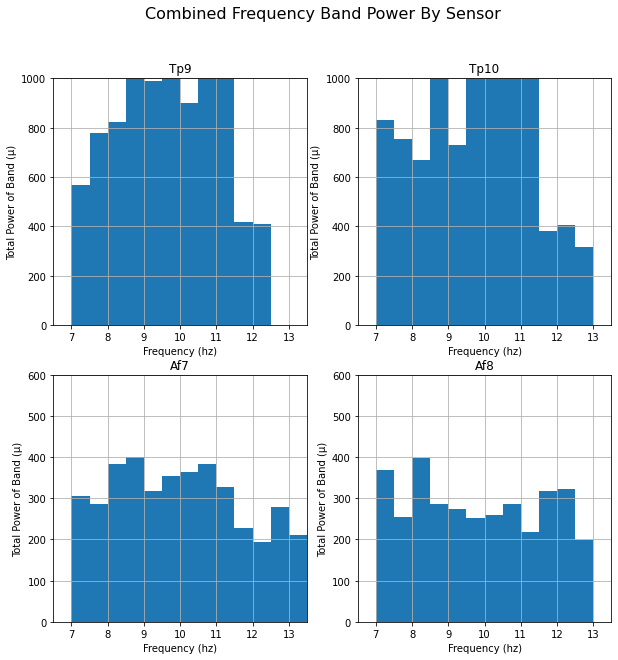

In [23]:
#Plot summed peak powers by frequency band

bin_res = np.arange(7,13, sr/fft_len)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,10))
fig.suptitle('Combined Frequency Band Power By Sensor', fontsize=16)

#Figure Windows
ylim1=1000
ylim2=600

ax1.grid(True)
ax1.set_ylim(0,ylim1)
ax1.set_xlim(6.5,13.5)

ax2.grid(True)
ax2.set_ylim(0,ylim1)
ax2.set_xlim(6.5,13.5)

ax3.grid(True)
ax3.set_ylim(0,ylim2)
ax3.set_xlim(6.5,13.5)

ax4.grid(True)
ax4.set_ylim(0,ylim2)
ax4.set_xlim(6.5,13.5)

ax1.set_title('Tp9')
ax1.set_xlabel('Frequency (hz)')
ax1.set_ylabel('Total Power of Band (µ)')

ax2.set_title('Tp10')
ax2.set_xlabel('Frequency (hz)')
ax2.set_ylabel('Total Power of Band (µ)')

ax3.set_title('Af7')
ax3.set_xlabel('Frequency (hz)')
ax3.set_ylabel('Total Power of Band (µ)')

ax4.set_title('Af8')
ax4.set_xlabel('Frequency (hz)')
ax4.set_ylabel('Total Power of Band (µ)')

ax1.bar(tp9_IAF, tp9_IAF_pow, width=sr/fft_len, align="edge")
ax2.bar(tp10_IAF, tp10_IAF_pow, width=sr/fft_len, align="edge")
ax3.bar(af7_IAF, af7_IAF_pow, width=sr/fft_len, align="edge")
ax4.bar(af8_IAF, af8_IAF_pow, width=sr/fft_len, align="edge")

plt.savefig(f'./{IMAGE_FOLDER}/{IMAGE_FILE_LABEL}_BandPowerbySensor.png', bbox_inches='tight')

In [ ]:
#Plot Combined Anterior Sensors and Temporal Sensors

fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2, figsize=(10,10))

IAF_TP = tp9_IAF + tp10_IAF
IAF_AF = af7_IAF + af8_IAF

IAF_TP_pow = tp9_IAF_pow + tp10_IAF_pow
IAF_AF_pow = af7_IAF_pow + af8_IAF_pow

ylim1=1000
ylim2=100

ax1.grid(True)
ax1.set_ylim(0,ylim1)
ax1.set_xlim(6.5,13.5)

ax2.grid(True)
ax2.set_ylim(0,ylim1)
ax2.set_xlim(6.5,13.5)

ax3.grid(True)
ax3.set_ylim(0,ylim2)
ax3.set_xlim(6.5,13.5)

ax4.grid(True)
ax4.set_ylim(0,ylim2)
ax4.set_xlim(6.5,13.5)

ax1.set_title('Tp9 + Tp10')
ax1.bar(IAF_TP, IAF_TP_pow, align='edge', width=sr/fft_len)
ax1.set_xlabel('Frequency (hz)')
ax1.set_ylabel('Summed Power of Peak Bands')

ax2.set_title('Af7 + Af8')
ax2.bar(IAF_AF, IAF_AF_pow, align='edge', width=sr/fft_len)
ax2.set_xlabel('Frequency (hz)')
ax2.set_ylabel('Summed Power of Peak Bands')

ax3.set_title('Freq of Tp9 + Tp10 peaks')
ax3.hist(IAF_TP, bin_res)
ax3.set_xlabel('Frequency (hz)')
ax3.set_ylabel('Occurences as Peak Signal')

ax4.set_title('Freq of Af7 + Af8 peaks')
ax4.hist(IAF_AF, bin_res)
ax4.set_xlabel('Frequency (hz)')
ax4.set_ylabel('Occurences as Peak Signal')

plt.savefig(f'./{IMAGE_FOLDER}/{IMAGE_FILE_LABEL}_IAFcandidates.png', bbox_inches='tight')